# **Import libraries**

In [34]:
!pip install pmdarima
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

# **Load the Dataset**

In [10]:
df = pd.read_csv('/kaggle/input/stock-market-dataset/stocks/NVDA.csv',parse_dates=['Date'])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-01-22,1.750000,1.953125,1.552083,1.640625,1.509998,67867200.0
1,1999-01-25,1.770833,1.833333,1.640625,1.812500,1.668188,12762000.0
2,1999-01-26,1.833333,1.869792,1.645833,1.671875,1.538759,8580000.0
3,1999-01-27,1.677083,1.718750,1.583333,1.666667,1.533965,6109200.0
4,1999-01-28,1.666667,1.677083,1.651042,1.661458,1.529172,5688000.0


# **Basic Analysis**

In [11]:
print('Basic information about the data:' ,df.info())
print('\n\nNull values:\n', df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5334 entries, 0 to 5333
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5334 non-null   datetime64[ns]
 1   Open       5333 non-null   float64       
 2   High       5333 non-null   float64       
 3   Low        5333 non-null   float64       
 4   Close      5333 non-null   float64       
 5   Adj Close  5333 non-null   float64       
 6   Volume     5333 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 291.8 KB
Basic information about the data: None


Null values:
 Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64


# **Drop null values**

In [12]:
df = df.dropna()
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# **Sessional Trend of the closing price**

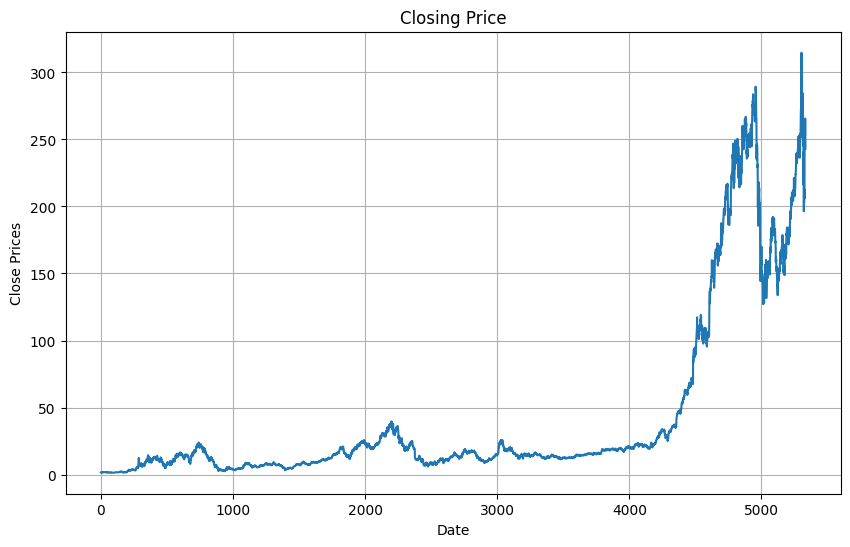

In [13]:
# plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('Closing Price')
plt.show()

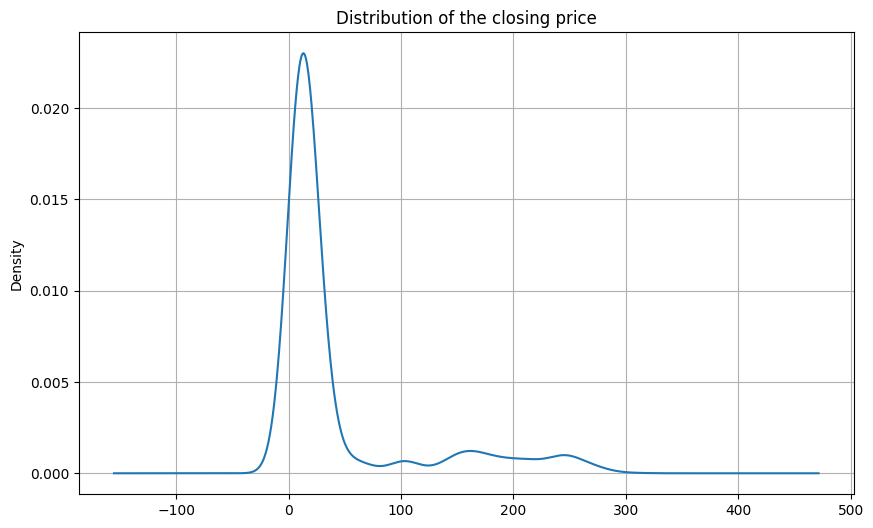

In [14]:
plt.figure(figsize=(10,6))
df_close = df['Close']
df_close.plot(kind='kde', title = 'Distribution of the closing price')
plt.grid(True)
plt.show()

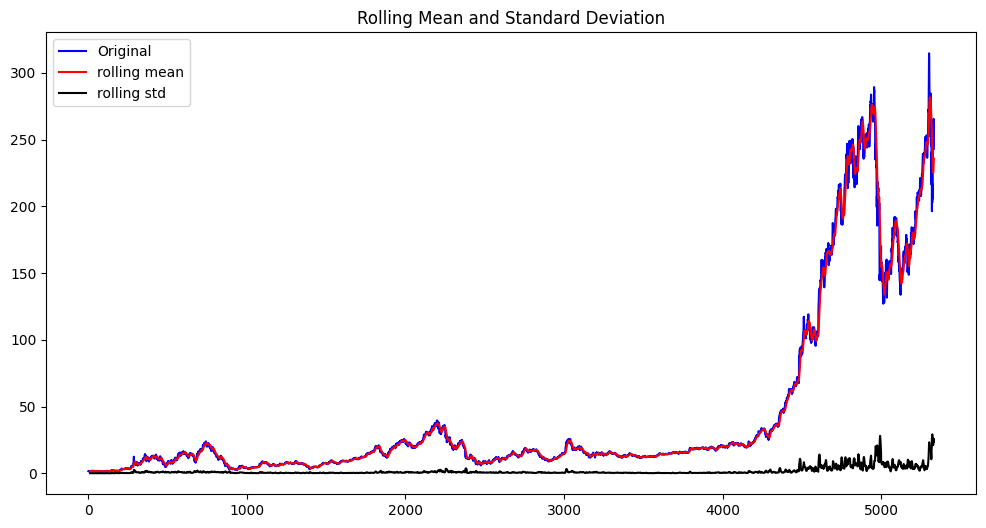

Dicky Fuller Test
Test Statistics                   0.214695
p-value                           0.973074
No. of lags used                 32.000000
Number of observations used    5300.000000
critical value (1%)              -3.431584
critical value (5%)              -2.862085
critical value (10%)             -2.567060
dtype: float64


In [16]:
# stationary test
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    plt.figure(figsize=(12,6))
    plt.plot(timeseries,color='blue',label='Original')
    plt.plot(rolmean,color='red',label='rolling mean')
    plt.plot(rolstd,color='black',label='rolling std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print('Dicky Fuller Test')
    adft = adfuller(timeseries,autolag='AIC')

    output = pd.Series(adft[0:4], index =['Test Statistics', 'p-value','No. of lags used', 'Number of observations used'])

    for key, values in adft[4].items():
        output['critical value (%s)'%key] = values

    print(output)
    
test_stationarity(df_close)

# **Eliminate Trend and Seasonality**

<Figure size 640x480 with 0 Axes>

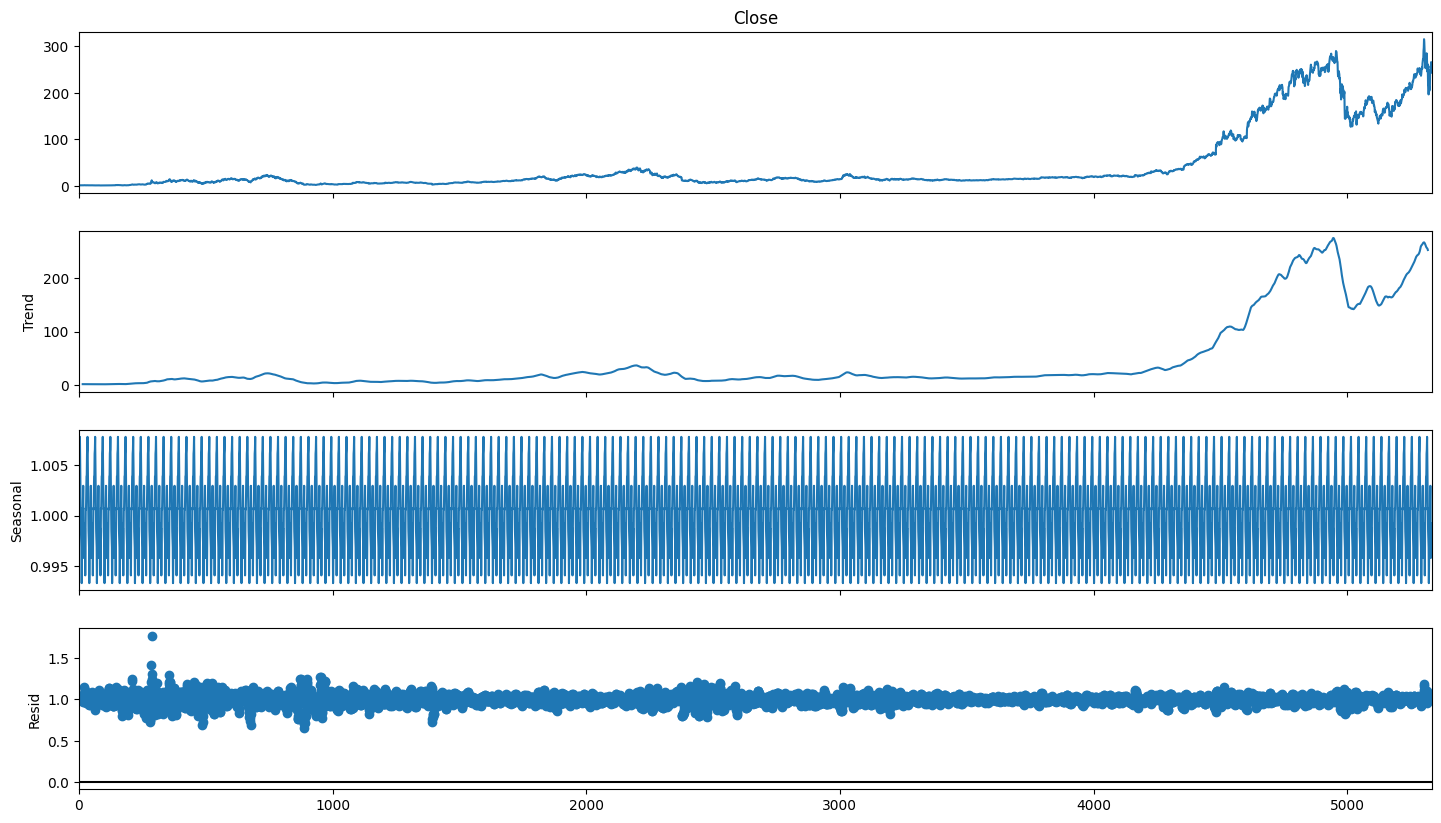

In [22]:
result = seasonal_decompose(df_close,model='multiplicative',period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16,9)
plt.show()

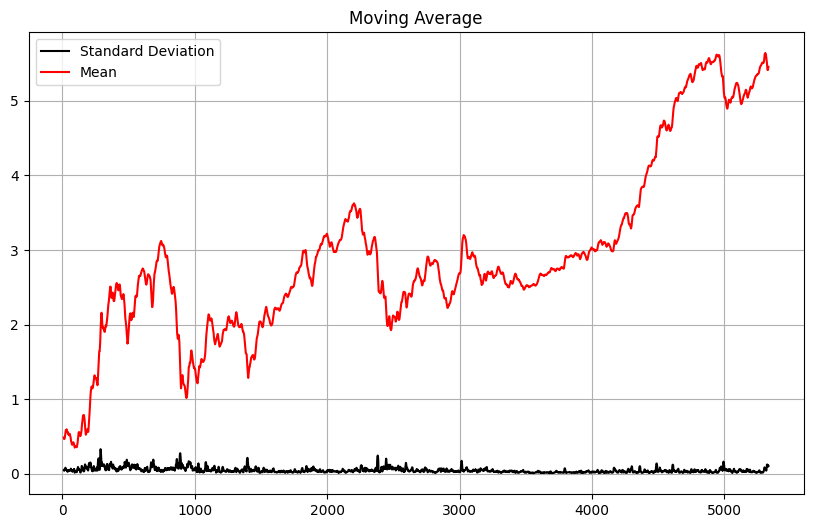

In [26]:
#Eliminate trend
from pylab import rcParams

rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.grid(True)
plt.show()

# **Split data into training and testing part**

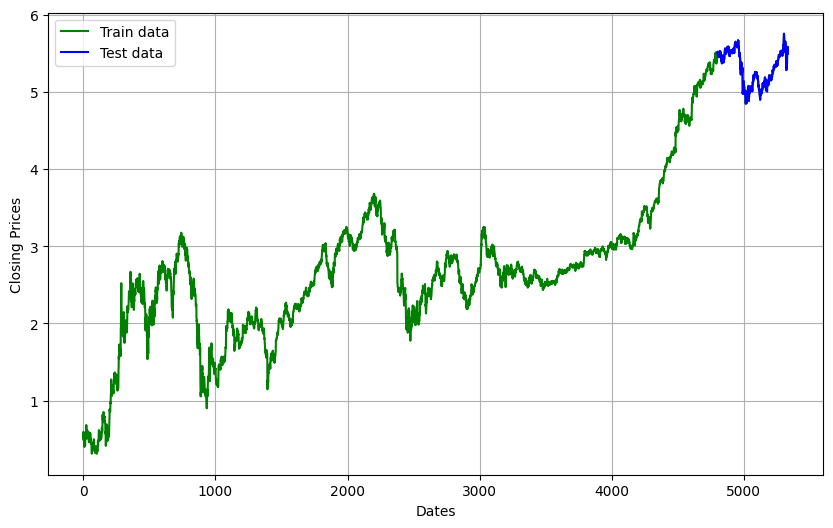

In [27]:
#split data into train and training set

train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
plt.show()

# **Auto ARIMA Find the Best Parameters**

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-17432.104, Time=0.86 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-17431.545, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-17431.589, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-17430.730, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-17428.141, Time=1.79 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 3.869 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4796
Model:               SARIMAX(0, 1, 0)   Log Likelihood                8718.052
Date:                Wed, 09 Apr 2025   AIC                         -17432.104
Time:                        06:59:31   BIC                         -17419.153
Sample:                             0   HQIC                        -17427.555
                               - 4796                             

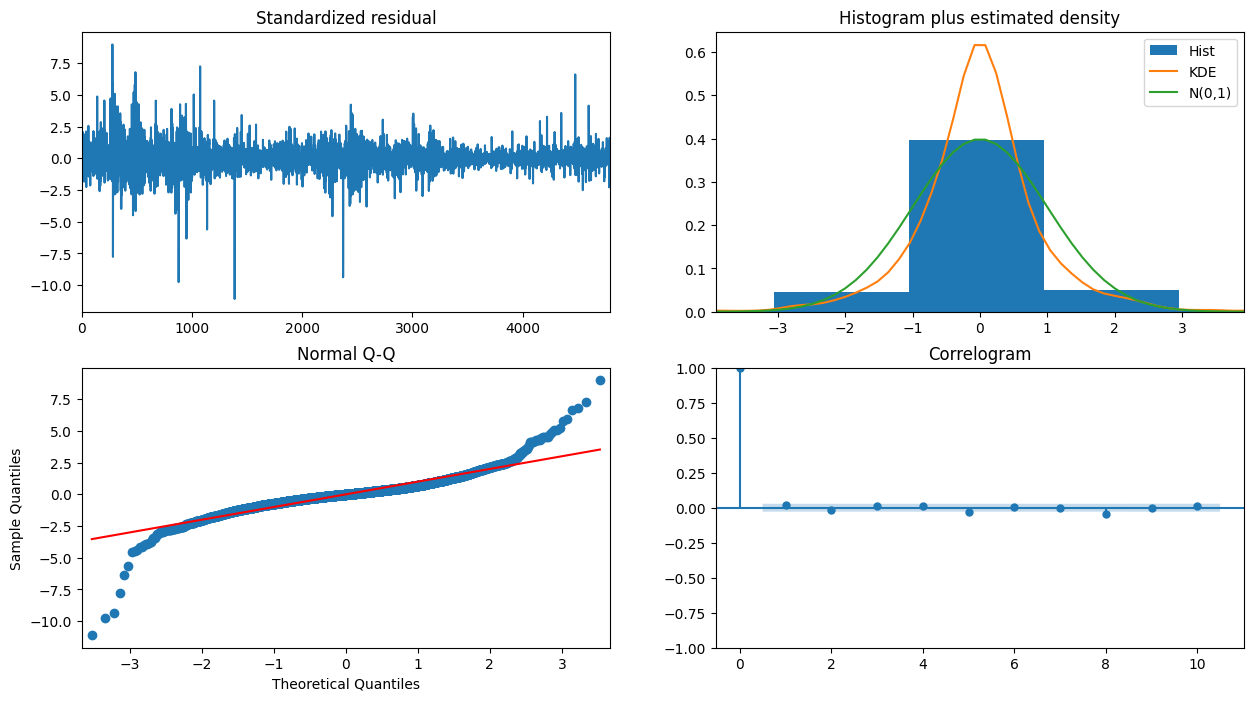

In [31]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

# **Modeling**

In [36]:

#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4796
Model:                 ARIMA(1, 1, 2)   Log Likelihood                8717.191
Date:                Wed, 09 Apr 2025   AIC                         -17426.382
Time:                        07:03:35   BIC                         -17400.480
Sample:                             0   HQIC                        -17417.285
                               - 4796                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7227      1.503     -0.481      0.631      -3.668       2.223
ma.L1          0.7412      1.501      0.494      0.621      -2.200       3.682
ma.L2          0.0112      0.032      0.350      0.7

# **Modeling and Forecasting**

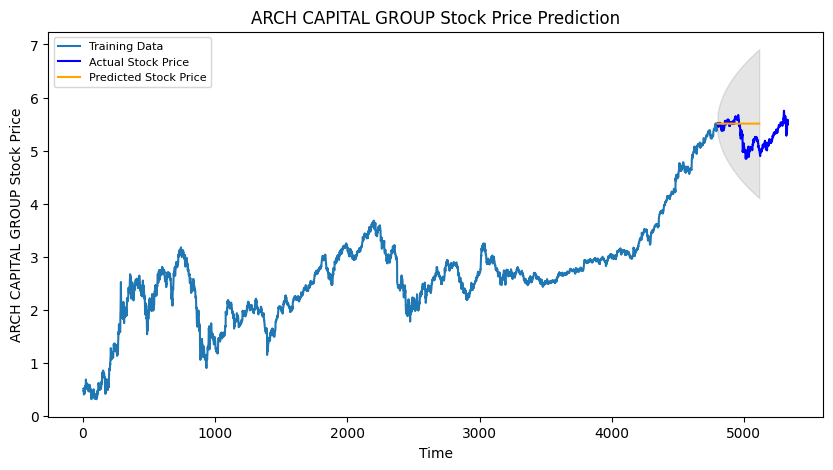

In [44]:
# Forecast
forecast_result = fitted.get_forecast(steps=321)
fc = forecast_result.predicted_mean
conf = forecast_result.conf_int(alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=0.1)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# **Evaluate Model Performance**

In [46]:
# Align test data to forecast length
aligned_test = test_data[:len(fc)]

# Then compute metrics
mse = mean_squared_error(aligned_test, fc)
mae = mean_absolute_error(aligned_test, fc)
rmse = math.sqrt(mse)
mape = np.mean(np.abs(fc - aligned_test) / np.abs(aligned_test)) * 100

# Print results
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


MSE: 0.0882
MAE: 0.2178
RMSE: 0.2970
MAPE: 4.18%


> **'with a MAPE of around 4.18% the model is 95.82 % accurate in predicting the next observations**